In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [2]:
data = pd.read_csv('criteo_sampled_data.csv')

In [3]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [4]:
cols = data.columns.values

# 数据预处理

## 定义特征组

In [5]:
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]

## 处理dense特征

In [6]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [7]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [10]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [11]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [12]:
total_data['label'] = data['label']

# AutoInt

## embedding层

### dense特征

在AutoInt中，dense特征也一样做了embedding，并用原始的dense值对embedding进行了scale

In [13]:
import tensorflow as tf

In [14]:
k=8

In [15]:
dense_inputs = []
for f in dense_feats:
    _input = Input([1], name=f)
    dense_inputs.append(_input)

In [16]:
dense_inputs

[<tf.Tensor 'I1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I5:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I7:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I8:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I9:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I10:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I11:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I12:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I13:0' shape=(None, 1) dtype=float32>]

In [17]:
dense_kd_embed = []
for i, _input in enumerate(dense_inputs):
    f = dense_feats[i]
    embed = tf.Variable(tf.random.truncated_normal(shape=(1, k), stddev=0.01), name=f)
    scaled_embed = tf.expand_dims(_input * embed, axis=1)
    dense_kd_embed.append(scaled_embed)

In [18]:
dense_kd_embed

[<tf.Tensor 'ExpandDims:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_2:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_3:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_4:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_5:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_6:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_7:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_8:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_9:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_10:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_11:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_12:0' shape=(None, 1, 8) dtype=float32>]

### sparse特征

In [19]:
sparse_inputs = []
for f in sparse_feats:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

In [20]:
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input)
    sparse_kd_embed.append(_embed)

In [21]:
sparse_kd_embed

[<tf.Tensor 'embedding/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_1/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_2/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_3/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_4/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_5/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_6/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_7/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_8/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_9/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_10/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_11/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_12/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_13/Identity:0' shape=(None, 1, 8) dtype=

### 合并embedding层

In [22]:
input_embeds = dense_kd_embed + sparse_kd_embed

##  Interacting Layer

In [23]:
# 构建feature map
embed_map = Concatenate(axis=1)(input_embeds)  # ?, 39, 8

In [28]:
def auto_interacting(embed_map, d=6, n_attention_head=2):
    """
    实现单层 AutoInt Interacting Layer
    @param embed_map: 输入的embedding feature map, (?, n_feats, n_dim)
    @param d: Q,K,V映射后的维度
    @param n_attention_head: multi-head attention的个数
    """
    assert len(embed_map.shape) == 3, "Input embedding feature map must be 3-D tensor."
    
    k = embed_map.shape[-1]
    
    # 存储多个self-attention的结果
    attention_heads = []
    W_Q = []
    W_K = []
    W_V = []
    
    # 1.构建多个attention
    for i in range(n_attention_head):
        # 初始化W_Q, W_K, W_V
        W_Q.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="query_"+str(i)))  # k, d
        W_K.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="key_"+str(i)))  # k, d
        W_V.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="value_"+str(i)))  # k, d
     
    for i in range(n_attention_head):
        # 映射到d维空间
        embed_q = tf.matmul(embed_map, W_Q[i])  # ?, 39, d
        embed_k = tf.matmul(embed_map, W_K[i])  # ?, 39, d
        embed_v = tf.matmul(embed_map, W_V[i])  # ?, 39, d
    
        # 计算attention
        energy = tf.matmul(embed_q, tf.transpose(embed_k, [0, 2, 1]))  # ?, 39, 39
        attention = tf.nn.softmax(energy)  # ?, 39, 39
    
        attention_output = tf.matmul(attention, embed_v)  # ?, 39, d
        attention_heads.append(attention_output)
    
    # 2.concat multi head
    multi_attention_output = Concatenate(axis=-1)(attention_heads)  # ?, 39, n_attention_head*d
    
    # 3.ResNet
    w_res = tf.Variable(tf.random.truncated_normal(shape=(k, d*n_attention_head)), name="w_res_"+str(i))  # k, d*n_attention_head
    output = Activation("relu")(multi_attention_output + tf.matmul(embed_map, w_res))  # ?, 39, d*n_attention_head)
    
    return output

In [29]:
def build_autoint(x0, n_layers):
    xl = x0
    for i in range(n_layers):
        xl = auto_interacting(xl, d=6, n_attention_head=2)
    
    return xl

In [30]:
# 构建3层interacting layer
autoint_layer = build_autoint(embed_map, 3)

In [32]:
autoint_layer = Flatten()(autoint_layer)

In [33]:
autoint_layer

<tf.Tensor 'flatten/Identity:0' shape=(None, 468) dtype=float32>

## 输出层

In [34]:
output_layer = Dense(1, activation="sigmoid")(autoint_layer)

## 编译模型

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [36]:
model = Model(dense_inputs+sparse_inputs, output_layer)

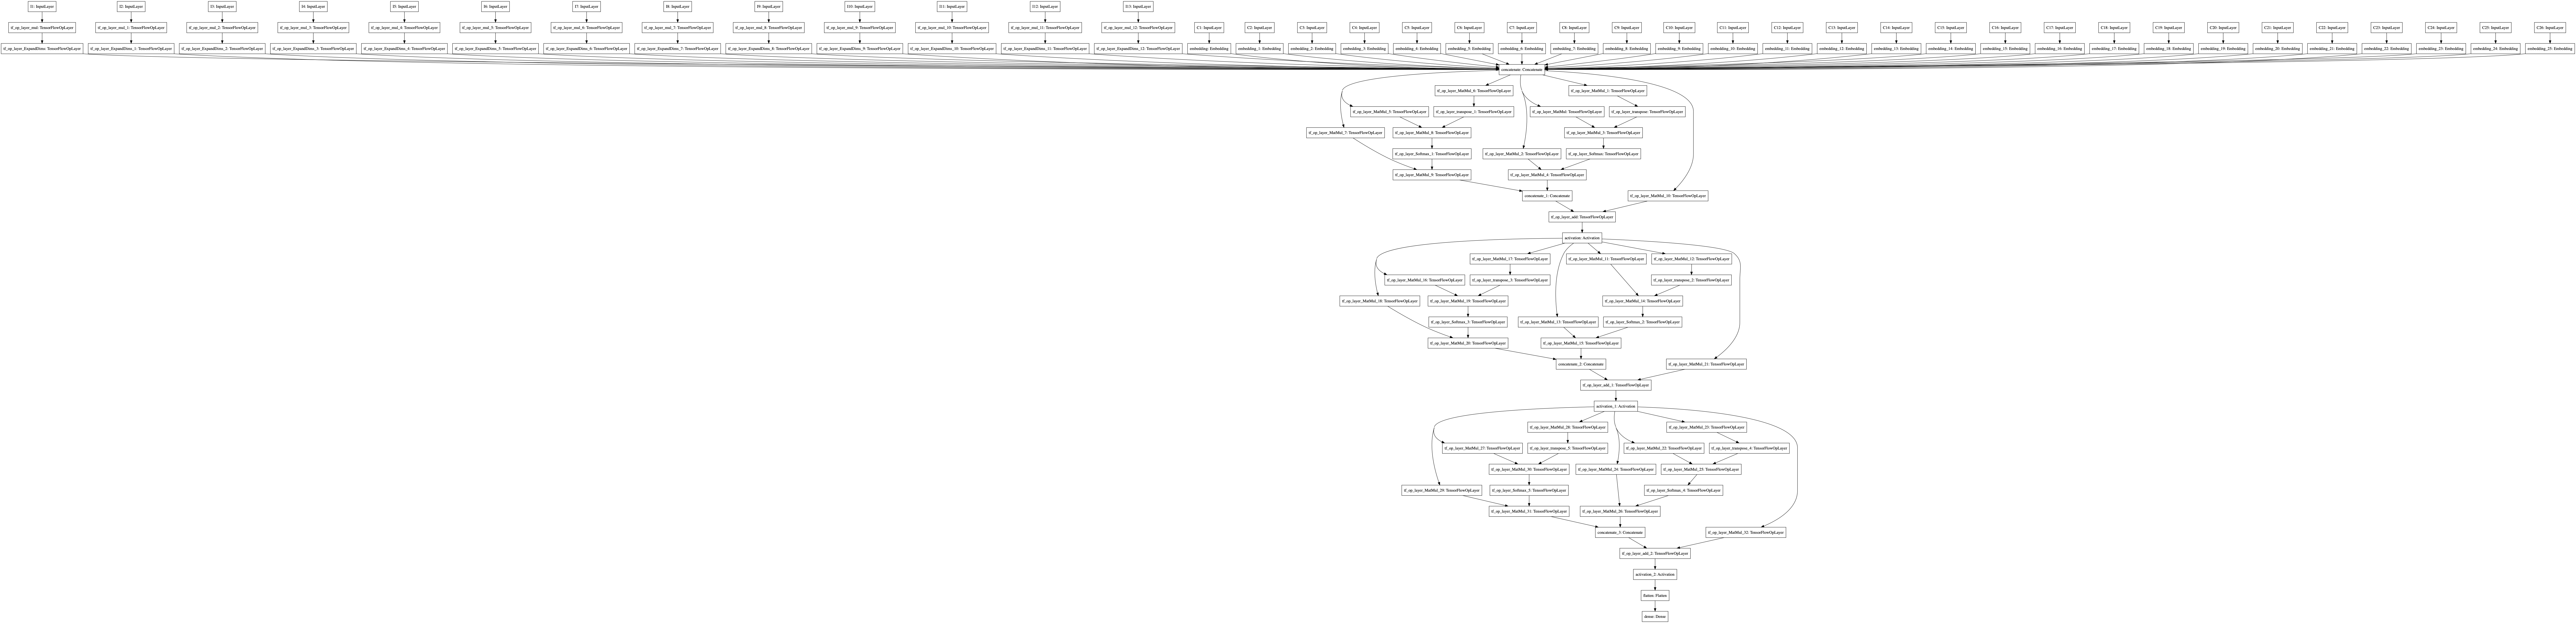

In [39]:
plot_model(model, "autoint.png")

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I4 (InputLayer)                 [(None, 1)]          0                                            
______________________________________________________________________________________________

In [41]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

## 训练

In [43]:
from tensorflow.keras.callbacks import TensorBoard

In [44]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0, 
                 write_graph=True,  
                 write_grads=True,
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [45]:
train_data = total_data.loc[:500000-1]
valid_data = total_data.loc[500000:]

In [46]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [47]:
train_label = [train_data['label'].values]

In [48]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [49]:
val_label = [valid_data['label'].values]

In [50]:
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label), 
          callbacks=[tbCallBack])

Train on 500000 samples, validate on 100000 samples
Epoch 1/5


/Users/Nelson/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/Nelson/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500000/500000 [==============================] - 178s 356us/sample - loss: 21.6365 - binary_crossentropy: 0.5133 - auc: 0.7136 - val_loss: 0.5886 - val_binary_crossentropy: 0.5088 - val_auc: 0.7265
Epoch 2/5
500000/500000 [==============================] - 165s 330us/sample - loss: 0.6046 - binary_crossentropy: 0.5010 - auc: 0.7328 - val_loss: 0.6353 - val_binary_crossentropy: 0.5045 - val_auc: 0.7320
Epoch 3/5
500000/500000 [==============================] - 166s 332us/sample - loss: 0.6396 - binary_crossentropy: 0.4978 - auc: 0.7375 - val_loss: 0.6649 - val_binary_crossentropy: 0.5033 - val_auc: 0.7333
Epoch 4/5
500000/500000 [==============================] - 165s 331us/sample - loss: 0.6549 - binary_crossentropy: 0.4965 - auc: 0.7391 - val_loss: 0.6698 - val_binary_crossentropy: 0.5019 - val_auc: 0.7360
Epoch 5/5
500000/500000 [==============================] - 166s 332us/sample - loss: 0.6610 - binary_crossentropy: 0.4955 - auc: 0.7406 - val_loss: 0.6720 - val_binary_crossentropy:

In [228]:
train_data[train_data.label==1]

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,label
7,0.693147,1.609438,1.098612,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,...,1648,0,0,51963,0,2,18107,0,0,1
12,0.000000,-1.000000,0.000000,0.000000,7.290293,0.000000,2.890372,0.000000,1.609438,0.000000,...,3251,0,0,152796,0,2,22439,0,0,1
13,0.000000,1.098612,2.484907,1.791759,9.236300,3.555348,1.098612,1.609438,1.791759,0.000000,...,1929,154,2,100495,0,2,20043,37,13026,1
16,0.693147,6.895683,0.000000,1.098612,4.663439,1.098612,0.693147,1.098612,1.098612,0.693147,...,1248,213,3,37088,0,2,22291,1,16213,1
20,0.000000,3.871201,0.000000,0.000000,8.764053,3.663562,2.995732,2.397895,4.969813,0.000000,...,373,0,0,139493,0,2,28476,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499982,1.386294,4.532599,0.000000,1.386294,0.693147,0.000000,2.302585,2.833213,2.833213,0.693147,...,3535,213,2,134033,9,2,22918,1,5619,1
499989,0.000000,-1.000000,0.000000,0.000000,7.252762,3.663562,2.833213,3.401197,4.691348,0.000000,...,574,0,0,129322,11,4,27125,0,0,1
499990,1.098612,-1.000000,0.000000,0.000000,1.098612,0.000000,1.386294,0.000000,0.000000,0.693147,...,3290,328,3,107584,0,3,9316,44,2659,1
499996,0.693147,0.000000,1.609438,0.693147,6.381816,1.945910,1.386294,2.564949,4.369448,0.693147,...,55,561,3,68700,0,4,8662,52,19086,1


# Attention可视化

In [230]:
feats = dense_feats + sparse_feats

In [242]:
sample_data = list(train_data.loc[7][feats].values.reshape((-1,1)))

In [209]:
model.layers[100].get_output_at(0)

<tf.Tensor 'tf_op_layer_Softmax/Identity:0' shape=(None, 39, 39) dtype=float32>

In [258]:
attention_layer = Model(inputs=model.input,outputs=model.layers[102].get_output_at(0))

In [259]:
attention = attention_layer.predict(sample_data)

In [260]:
attention = attention.reshape((39, 39))

In [261]:
def plot_attention(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    ax.set_yticks(range(len(feats)))
    ax.set_yticklabels(feats)
    ax.set_xticks(range(len(feats)))
    ax.set_xticklabels(feats)
    
    im = ax.imshow(data)
    plt.colorbar(im)

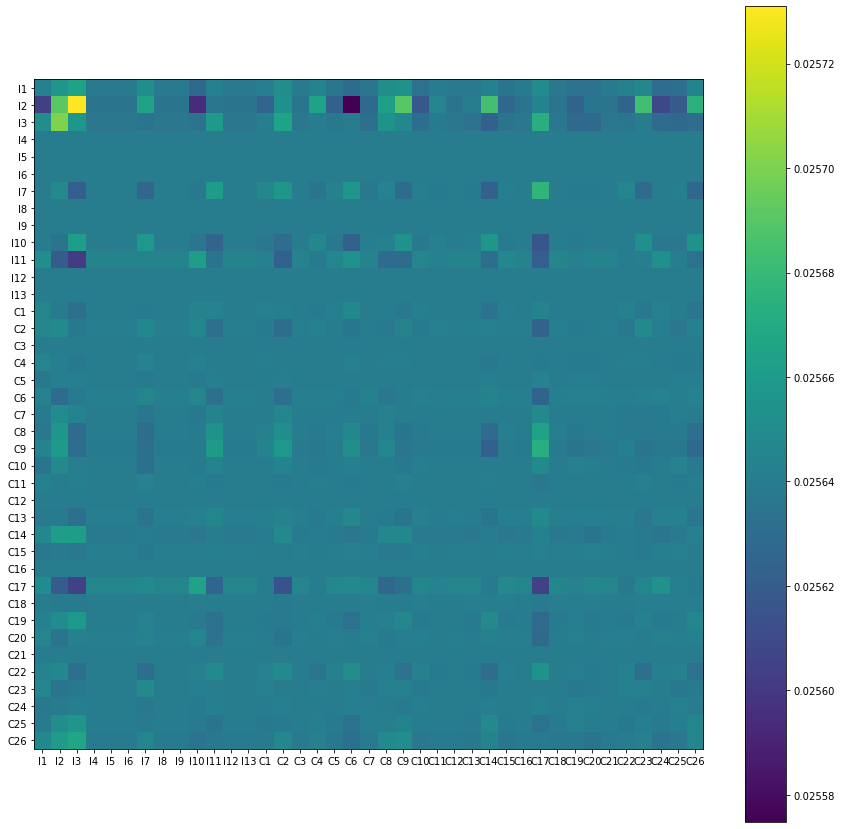

In [262]:
plot_attention(attention)